# What does CNN actually see?

In [121]:
import tensorflow as tf

*Author: Aleksandra Pestka*

The purpose of this notebook is to take a look at what deep convolutional neural networks really learn and how they understand the images we feed them. 

VGG16 (also called OxfordNet) trained on ImageNet is being used, as well as Keras - deep learning library for Python. <br> Thanks to Keras we will visualize inputs that maximize the activation of the filters in different layers of the VGG16 architecture.

## What is ImageNet?

**ImageNet** is formally a project aimed at (manually) labeling and categorizing images into almost 22,000 separate object categories for the purpose of computer vision research.

However, we hear the term *“ImageNet”* mostly in the context of image classification challenge - ILSVRC. The aim of this challenge is to train a model that can correctly classify an input image into 1,000 separate object categories. These 1,000 image categories represent object classes that we encounter in our day-to-day lives.

![Examples of classes and input images for ImageNet database.](ImageNet.png)

*<center> Examples of classes and input images for ImageNet database. </center>*

## What is VGG16?

VGG16 is a convolutional neural network architecture which is considered to be an excellent vision model.

![Architecture](Structure.png)

*<center> A visualization of the VGG architecture </center>*


This network is characterized by its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. Reducing volume size is handled by max pooling. Two fully-connected layers followed by a softmax classifier.

The “16” stands for the number of weight layers in the network.

## Let's get down to work

First of all, let's start by loading pretrained VGG16 model with ImageNet weights available in Keras.

In [122]:
from keras.applications import vgg16

model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')   

Model loaded.


To clarify: **include_top = False** will provide us VGG16 model without last 3 fully connected layers. <br>
By only keeping the convolutional modules, our model can be adapted to arbitrary input sizes.

In [123]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Choose the layer for visualization

LAYER_NAME is the variable provided by a user, so feel free to change it at will as long as it's a part of VGG's convolutional layers.

In [124]:
from keras import layers

LAYER_NAME = 'block4_conv3' 

if (LAYER_NAME in [layer.name for layer in model.layers if isinstance(layer,layers.Conv2D)]):
    layer_name = LAYER_NAME
    print("Chosen: ", layer_name)
else:
    print("Provide a valid conv layer name")

Chosen:  block4_conv3


## Visualize the output of individual filters in a given layer based on given input

The most straight-forward visualization technique is to show the activations of the network during the forward pass.

Let's load our sample image and preprocess it.

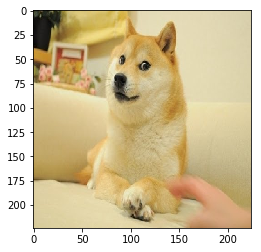

In [125]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open('dog.jpg')
img = img.resize((224,224))

plt.imshow(img)
plt.show()

Convert PIL Image into array and resize to 4 dimensions.

In [126]:
img = np.array(img)
img = img.reshape(1, img.shape[0], img.shape[1], 3)
print(img.shape)

(1, 224, 224, 3)


Get the intermediate layer output based on given input image.

In [127]:
from keras.models import Model

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

intermediate_output = intermediate_layer_model.predict(img)
print(intermediate_output.shape)

(1, 28, 28, 512)


In [128]:
output = np.squeeze(intermediate_output)
output = np.moveaxis(output, 2, 0)

print(output.shape)

(512, 28, 28)


Plot exemplary outputs of the layer.

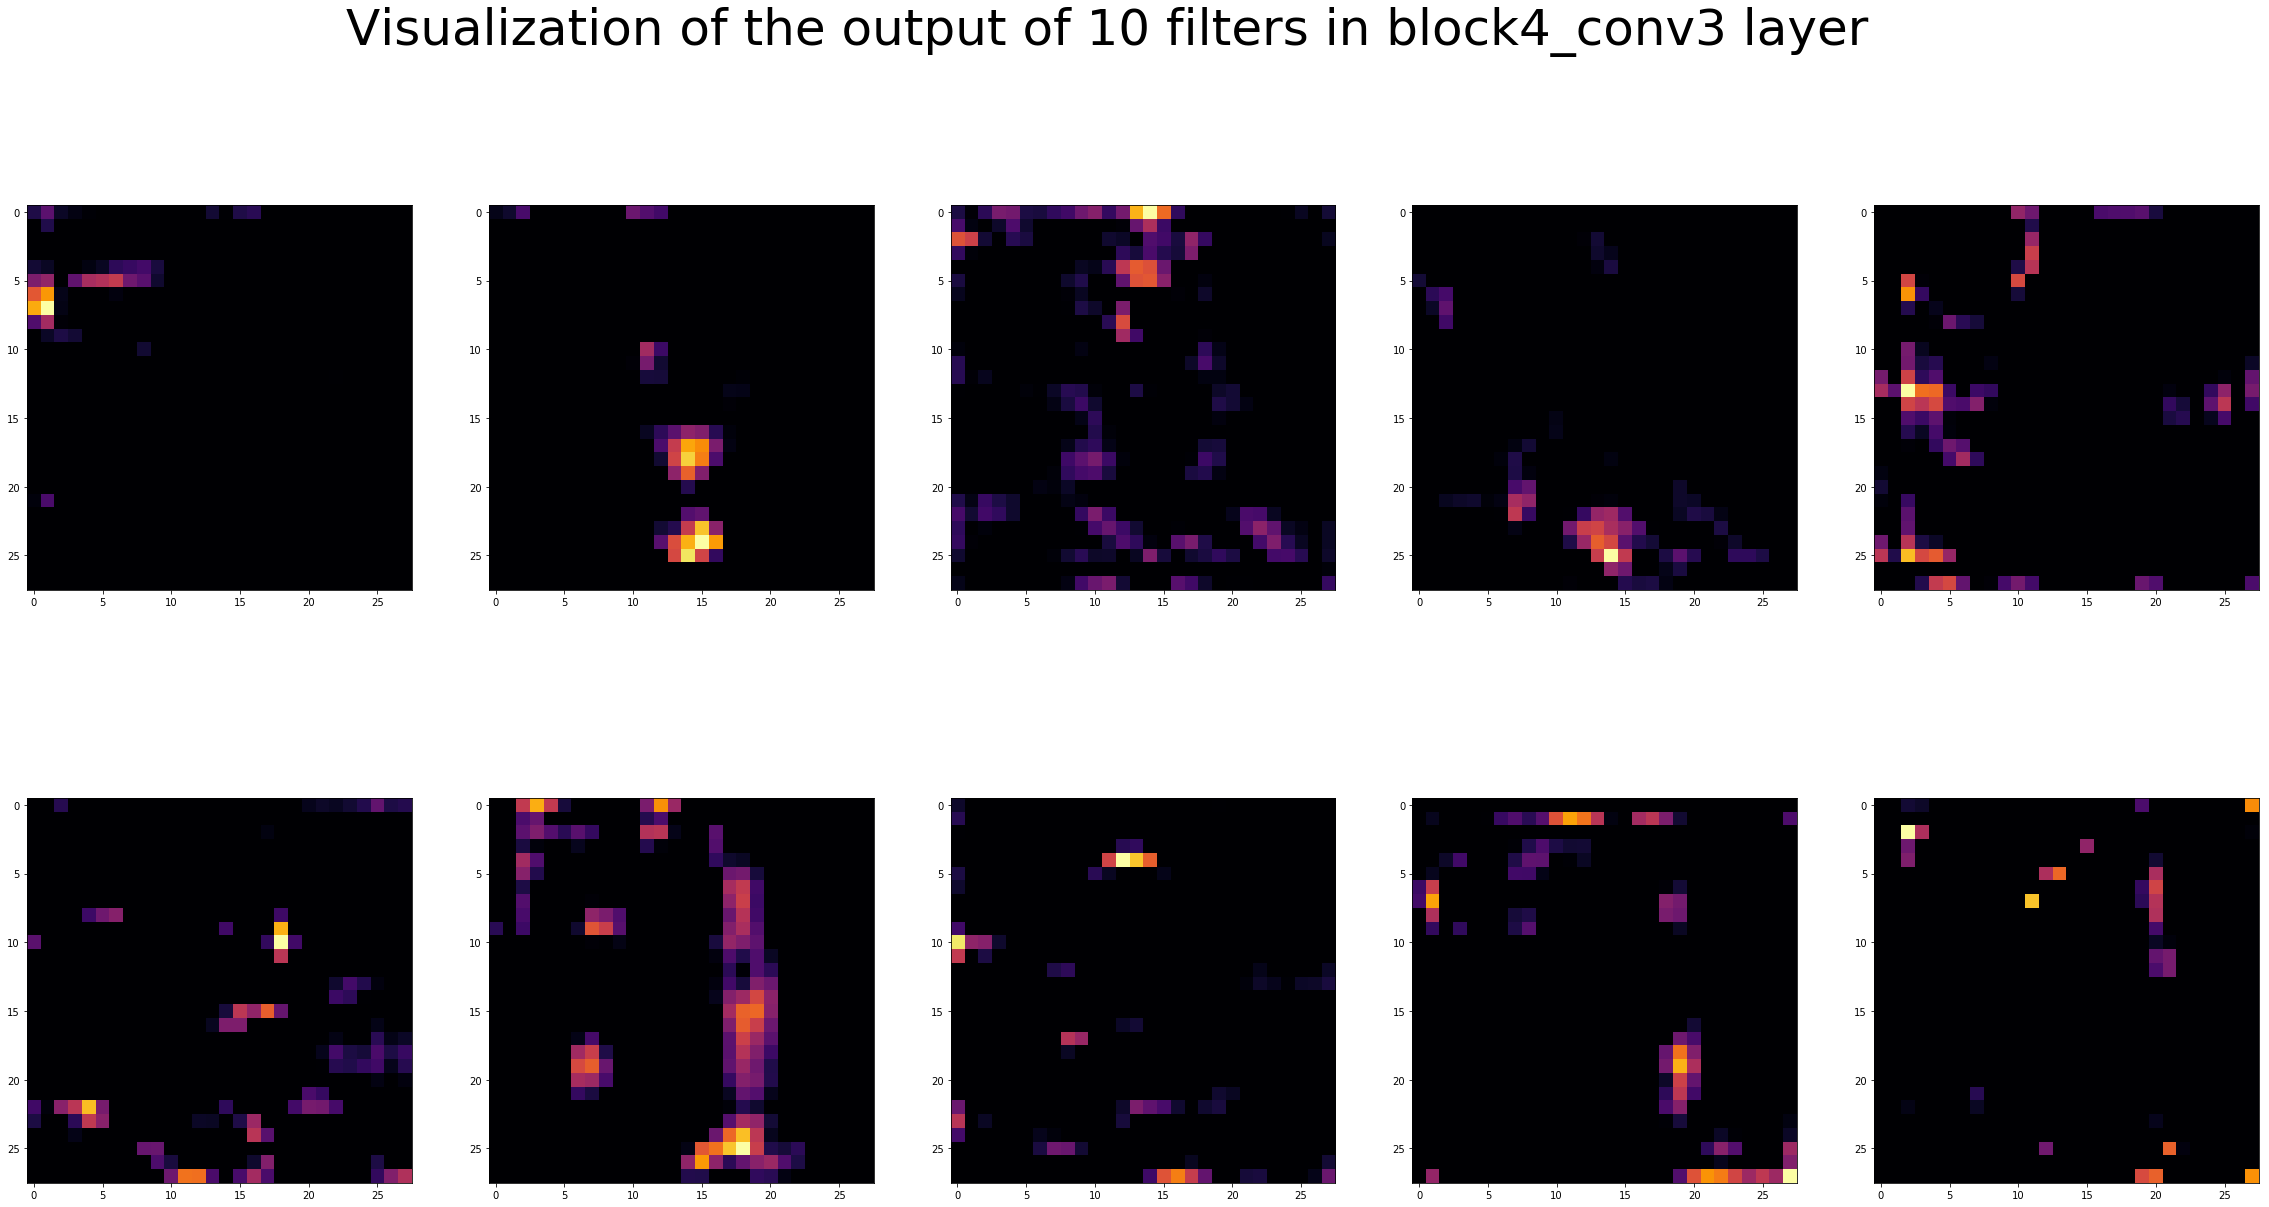

In [129]:
fig = plt.figure(figsize=(40, 20))

n_filters = 10 

cols = 5
rows = 2

plt.suptitle("Visualization of the output of {} filters in {} layer".format(n_filters, layer_name), fontsize = 50)

for i in range(n_filters):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(output[i], cmap='inferno')

Every box shows an activation map corresponding to some filter. Notice that the activations are sparse (most values are zero, in this visualization shown in black) and mostly local.

**For ReLU networks, the activations usually start out looking relatively blobby and dense, but as the training progresses the activations usually become more sparse and localized.**

**For better visualization - choose one of the initial CONV layer**

## Visualize the maximization of weights

The second common strategy is to visualize the weights. They are useful to visualize because well-trained networks usually display nice and smooth filters without any noisy patterns. 

In [130]:
from keras import backend as K

input_img = model.input

In [131]:
print("Chosen layer: ", layer_name)

Chosen layer:  block4_conv3


In [132]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_output = layer_dict[layer_name].output

In [133]:
print("Choose filter index to visualize out of {} available filters".format(layer_output.shape[-1]))

Choose filter index to visualize out of 512 available filters


In [134]:
filter_index = 50

Build a loss function that maximizes the activation of the nth filter of the layer considered. <br>
It will be the mean of all the values in the output layer filter.

In [135]:
loss_fun = K.mean(layer_output[:,:,:,filter_index])

Find gradient of loss.

In [136]:
gradient = K.gradients(loss_fun, input_img)[0]

Normalize the gradient.

In [137]:
gradient = gradient / (K.sqrt(K.mean(K.square(gradient))) + K.epsilon())

Instantiate a Keras function.

In [138]:
iterate = K.function([input_img], [loss_fun, gradient])

Define a function to convert a tensor into a valid image, which will be necessary for visualization in further steps.

In [139]:
from scipy.misc import imsave

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Set the step size for gradient to pass to input image (how much we want to learn from gradient) and apply **GRADIENT ASCENT METHOD**. 

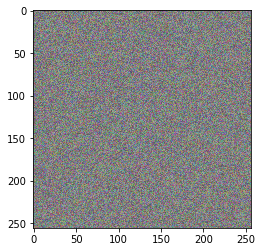

In [140]:
step_size = 1
steps = 100

input_img_data = np.random.random((1, 256, 256, 3))*20 + 128 #generate random noisy image

raw_img_data = deprocess_image(input_img_data[0])
plt.imshow(raw_img_data)

We want to see for a given filter which input image (noise) provides higher value of loss function which is the activation for that filter. So at the end of the iterations we will have an image which will maximize the activation of a given filter. Eventually we'll get most favorable input images that when feeded to the model it creates maximum activation for that particular filter.

**VERSION 2** Use your own image!

In [141]:
img_to_filter = img

In [142]:
for i in range(steps):
    loss, grads = iterate([img_to_filter]) #feed our image into Keras function
    img_to_filter = img_to_filter + grads*step_size #update random noisy image
    print("Step: {}/{}, Loss: {}".format(i+1, steps, loss))

Step: 1/100, Loss: 1.7787964344024658
Step: 2/100, Loss: 25.603084564208984
Step: 3/100, Loss: 72.05845642089844
Step: 4/100, Loss: 129.4136199951172
Step: 5/100, Loss: 182.9916534423828
Step: 6/100, Loss: 238.5409393310547
Step: 7/100, Loss: 303.4071960449219
Step: 8/100, Loss: 365.726318359375
Step: 9/100, Loss: 436.96905517578125
Step: 10/100, Loss: 499.9566345214844
Step: 11/100, Loss: 567.9342041015625
Step: 12/100, Loss: 638.0206298828125
Step: 13/100, Loss: 705.7896728515625
Step: 14/100, Loss: 777.5323486328125
Step: 15/100, Loss: 844.5455932617188
Step: 16/100, Loss: 912.5325317382812
Step: 17/100, Loss: 979.8973388671875
Step: 18/100, Loss: 1042.765625
Step: 19/100, Loss: 1102.8795166015625
Step: 20/100, Loss: 1168.0941162109375
Step: 21/100, Loss: 1223.6656494140625
Step: 22/100, Loss: 1286.1490478515625
Step: 23/100, Loss: 1341.626220703125
Step: 24/100, Loss: 1403.348388671875
Step: 25/100, Loss: 1454.1832275390625
Step: 26/100, Loss: 1513.753662109375
Step: 27/100, Loss: 

In [143]:
img_to_filter = img_to_filter[0] #get the data in 3 dimensions
img = deprocess_image(img_to_filter)

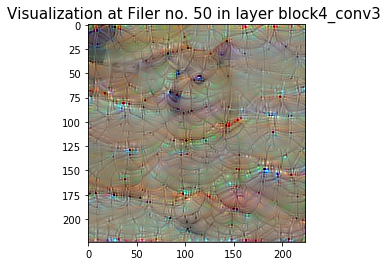

In [144]:
plt.title("Visualization at Filer no. {} in layer {} ".format(filter_index, layer_name), fontsize=15)
plt.imshow(img)

**The deeper layer you choose the more complex pattern will be plotted**.

## References

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/

http://cs231n.github.io/understanding-cnn/

https://github.com/meet-minimalist/Visualize-CNN-Filters